  # 📌 Klasifikasi Pendapatan dengan Naive Bayes dan Logistic Regression
  Pada tugas ini, kita akan menggunakan Adult Census Income Dataset. Dataset bisa diakses melalui link berikut:\
  🔗 https://www.kaggle.com/datasets/uciml/adult-census-income/data

  Tujuan utama dari tugas ini adalah membangun model Naive Bayes dan Logistic Regression untuk memprediksi apakah pendapatan seseorang lebih dari $50K per tahun berdasarkan fitur demografis dan pekerjaan.

  Langkah-langkah yang harus dilakukan antara lain:
  1. Persiapan Dataset & Eksplorasi Awal
  - Memuat dataset, melihat struktur data, tipe fitur (numerik atau kategorikal), dan distribusi label.

  2. Preprocessing
  - Memproses data agar siap untuk digunakan dalam model, termasuk menangani missing value, encoding fitur kategorikal, dan normalisasi/standardisasi jika diperlukan.

  3. Eksperimen Model 
  - Bangun model Naive Bayes dan Logistic Regression dan latih menggunakan data training.
  - Eksperimen dapat dilakukan dengan pemilihan fitur yang digunakan dalam melatih model untuk mengetahui pengaruh fitur terhadap performa model.

  4. Evaluasi Model
  - Hitung metrik evaluasi seperti Accuracy, Precision, Recall, F1-Score, serta visualisasikan Confusion Matrix untuk setiap kombinasi fitur yang diuji.

  5. Analisis & Kesimpulan
  - Membandingkan performa antar eksperimen fitur, menentukan kombinasi fitur terbaik, dan menarik kesimpulan mengenai pengaruh fitur terhadap kemampuan model dalam memprediksi pendapatan.

# 1. Import Library

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 2. Load Dataset




In [51]:
df = pd.read_csv("adult.csv")

print(df.shape)
print()
print(df.info())


(32561, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


# 3. Eksplorasi Data


In [52]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [53]:
#cek missing value yang ditulis dengan tanda "?"
missing_counts = (df == "?").sum()
print(missing_counts)

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [54]:
target_dist = df["income"].value_counts()
print(target_dist)

income
<=50K    24720
>50K      7841
Name: count, dtype: int64


C:\Users\radit\AppData\Local\Temp\ipykernel_21800\1157649953.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="income", palette="Set2")


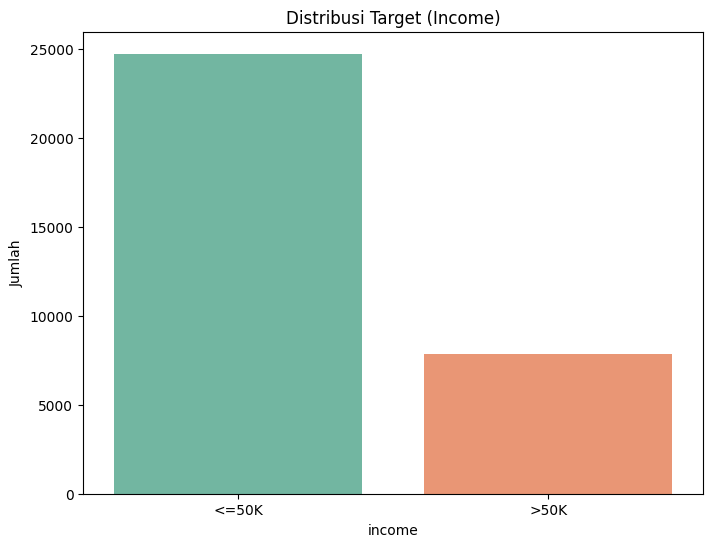

In [55]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x="income", palette="Set2")
plt.title("Distribusi Target (Income)")
plt.ylabel("Jumlah")
plt.show()

**Hasil:**

* `<=50K`: **75.9%**
* `>50K`: **24.1%**

 Dataset **imbalanced**, mayoritas responden punya pendapatan ≤ \$50K. Ini penting karena bisa mempengaruhi metrik evaluasi (accuracy mungkin misleading, jadi perlu precision, recall, F1).






### Insight Awal

1. Dataset berisi **32.561 sampel** dengan 15 fitur.
2. Terdapat **6 fitur numerik** dan **9 fitur kategorikal**.
3. Beberapa fitur kategorikal (`workclass`, `occupation`, `native.country`) mengandung missing value (`?`).
4. Target `income` imbalanced → mayoritas **<=50K**.
5. **Kolom `education` dan `education.num` berhubungan erat:**

   * `education` adalah kategori (misal: HS-grad, Bachelors).
   * `education.num` adalah versi numerik ordinal (misal: HS-grad = 9, Bachelors = 13).
   * Karena redundant, kita bisa drop salah satunya. Umumnya `education.num` dipertahankan karena sudah berbentuk angka.

   **Kolom `fnlwgt`:**
   * `fnlwgt` (final weight) adalah bobot sampel dari survei sensus.
   * Fungsi utamanya: merepresentasikan berapa banyak orang di populasi nyata yang diwakili oleh satu baris data.
   * Dalam analisis prediktif individu (income classification), fitur ini tidak membawa informasi personal, sehingga sering dianggap **tidak relevan**.
   

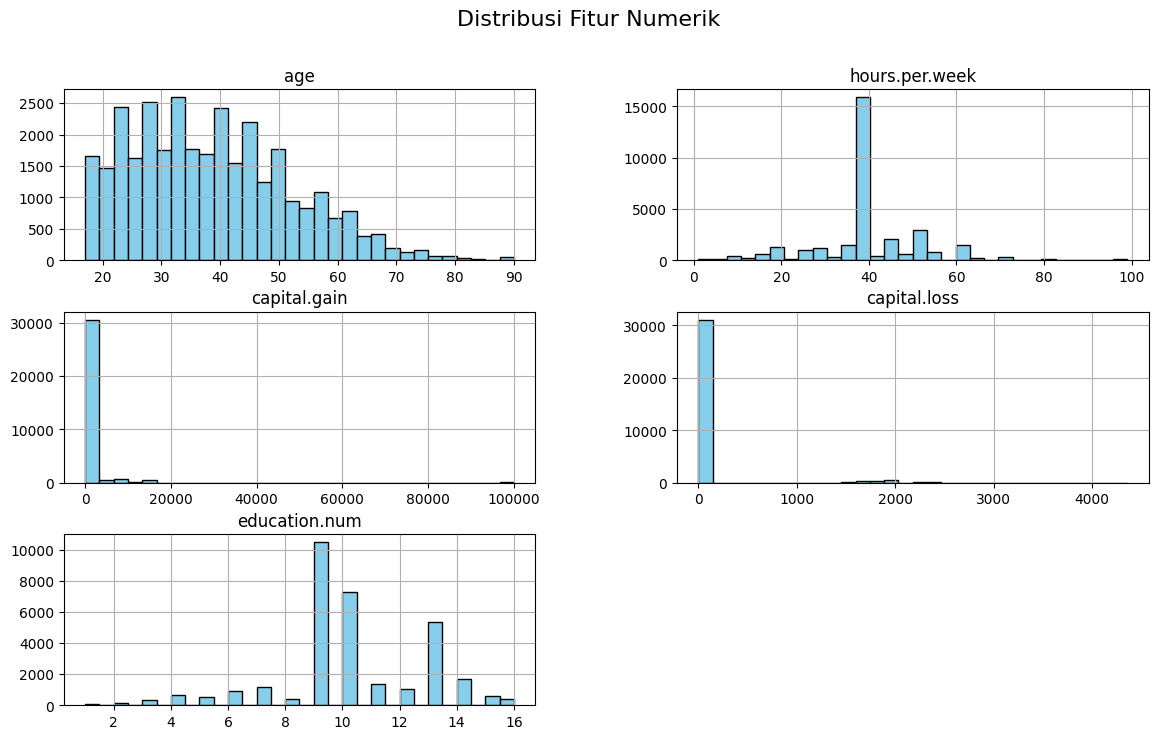

In [56]:
# Distribusi fitur numerik 
num_cols = ["age", "hours.per.week", "capital.gain", "capital.loss", "education.num"]
df[num_cols].hist(bins=30, figsize=(14,8), color="skyblue", edgecolor="black")
plt.suptitle("Distribusi Fitur Numerik", fontsize=16)
plt.show()

### Insight Distribusi Fitur Numerik

1. **Age (Umur)**

   * Distribusi mirip normal tapi condong ke umur produktif (20–50 tahun).
   * Mayoritas responden ada di kisaran **30–40 tahun**.
   * Sedikit orang berusia di atas 70 tahun → data lebih fokus ke angkatan kerja.

2. **Hours per Week (Jam Kerja per Minggu)**

   * Puncak tajam di **40 jam/minggu** → standar kerja penuh di AS.
   * Ada variasi lain (20 jam, 60 jam) tapi jauh lebih sedikit.
   * Distribusi ini bisa sangat berpengaruh ke pendapatan karena jam kerja biasanya berkorelasi dengan income.

3. **Capital Gain (Keuntungan Modal)**

   * Sangat **skewed ke kanan** (mayoritas = 0).
   * Hanya sedikit orang yang punya capital gain besar (outlier sampai >100k).
   * Artinya, fitur ini mungkin sangat informatif → yang punya capital gain cenderung berpenghasilan lebih tinggi.

4. **Capital Loss (Kerugian Modal)**

   * Polanya mirip dengan capital gain, mayoritas = 0.
   * Ada beberapa titik tertentu (misal sekitar 2000) yang sering muncul → menunjukkan aturan pajak tertentu.
   * Juga fitur potensial untuk memisahkan kelas income.

5. **Education Num (Tingkat Pendidikan)**

   * Nilai diskrit (1–16) sesuai level pendidikan.
   * Mayoritas responden ada di **9–10** (HS-grad dan Some-college).
   * Relatif sedikit yang mencapai 15–16 (Bachelor’s ke atas).
   * Ini konsisten dengan fitur kategorikal `education`, dan penting karena pendidikan biasanya faktor kunci dalam pendapatan.


C:\Users\radit\AppData\Local\Temp\ipykernel_21800\1766573704.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")
C:\Users\radit\AppData\Local\Temp\ipykernel_21800\1766573704.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")
C:\Users\radit\AppData\Local\Temp\ipykernel_21800\1766573704.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Se

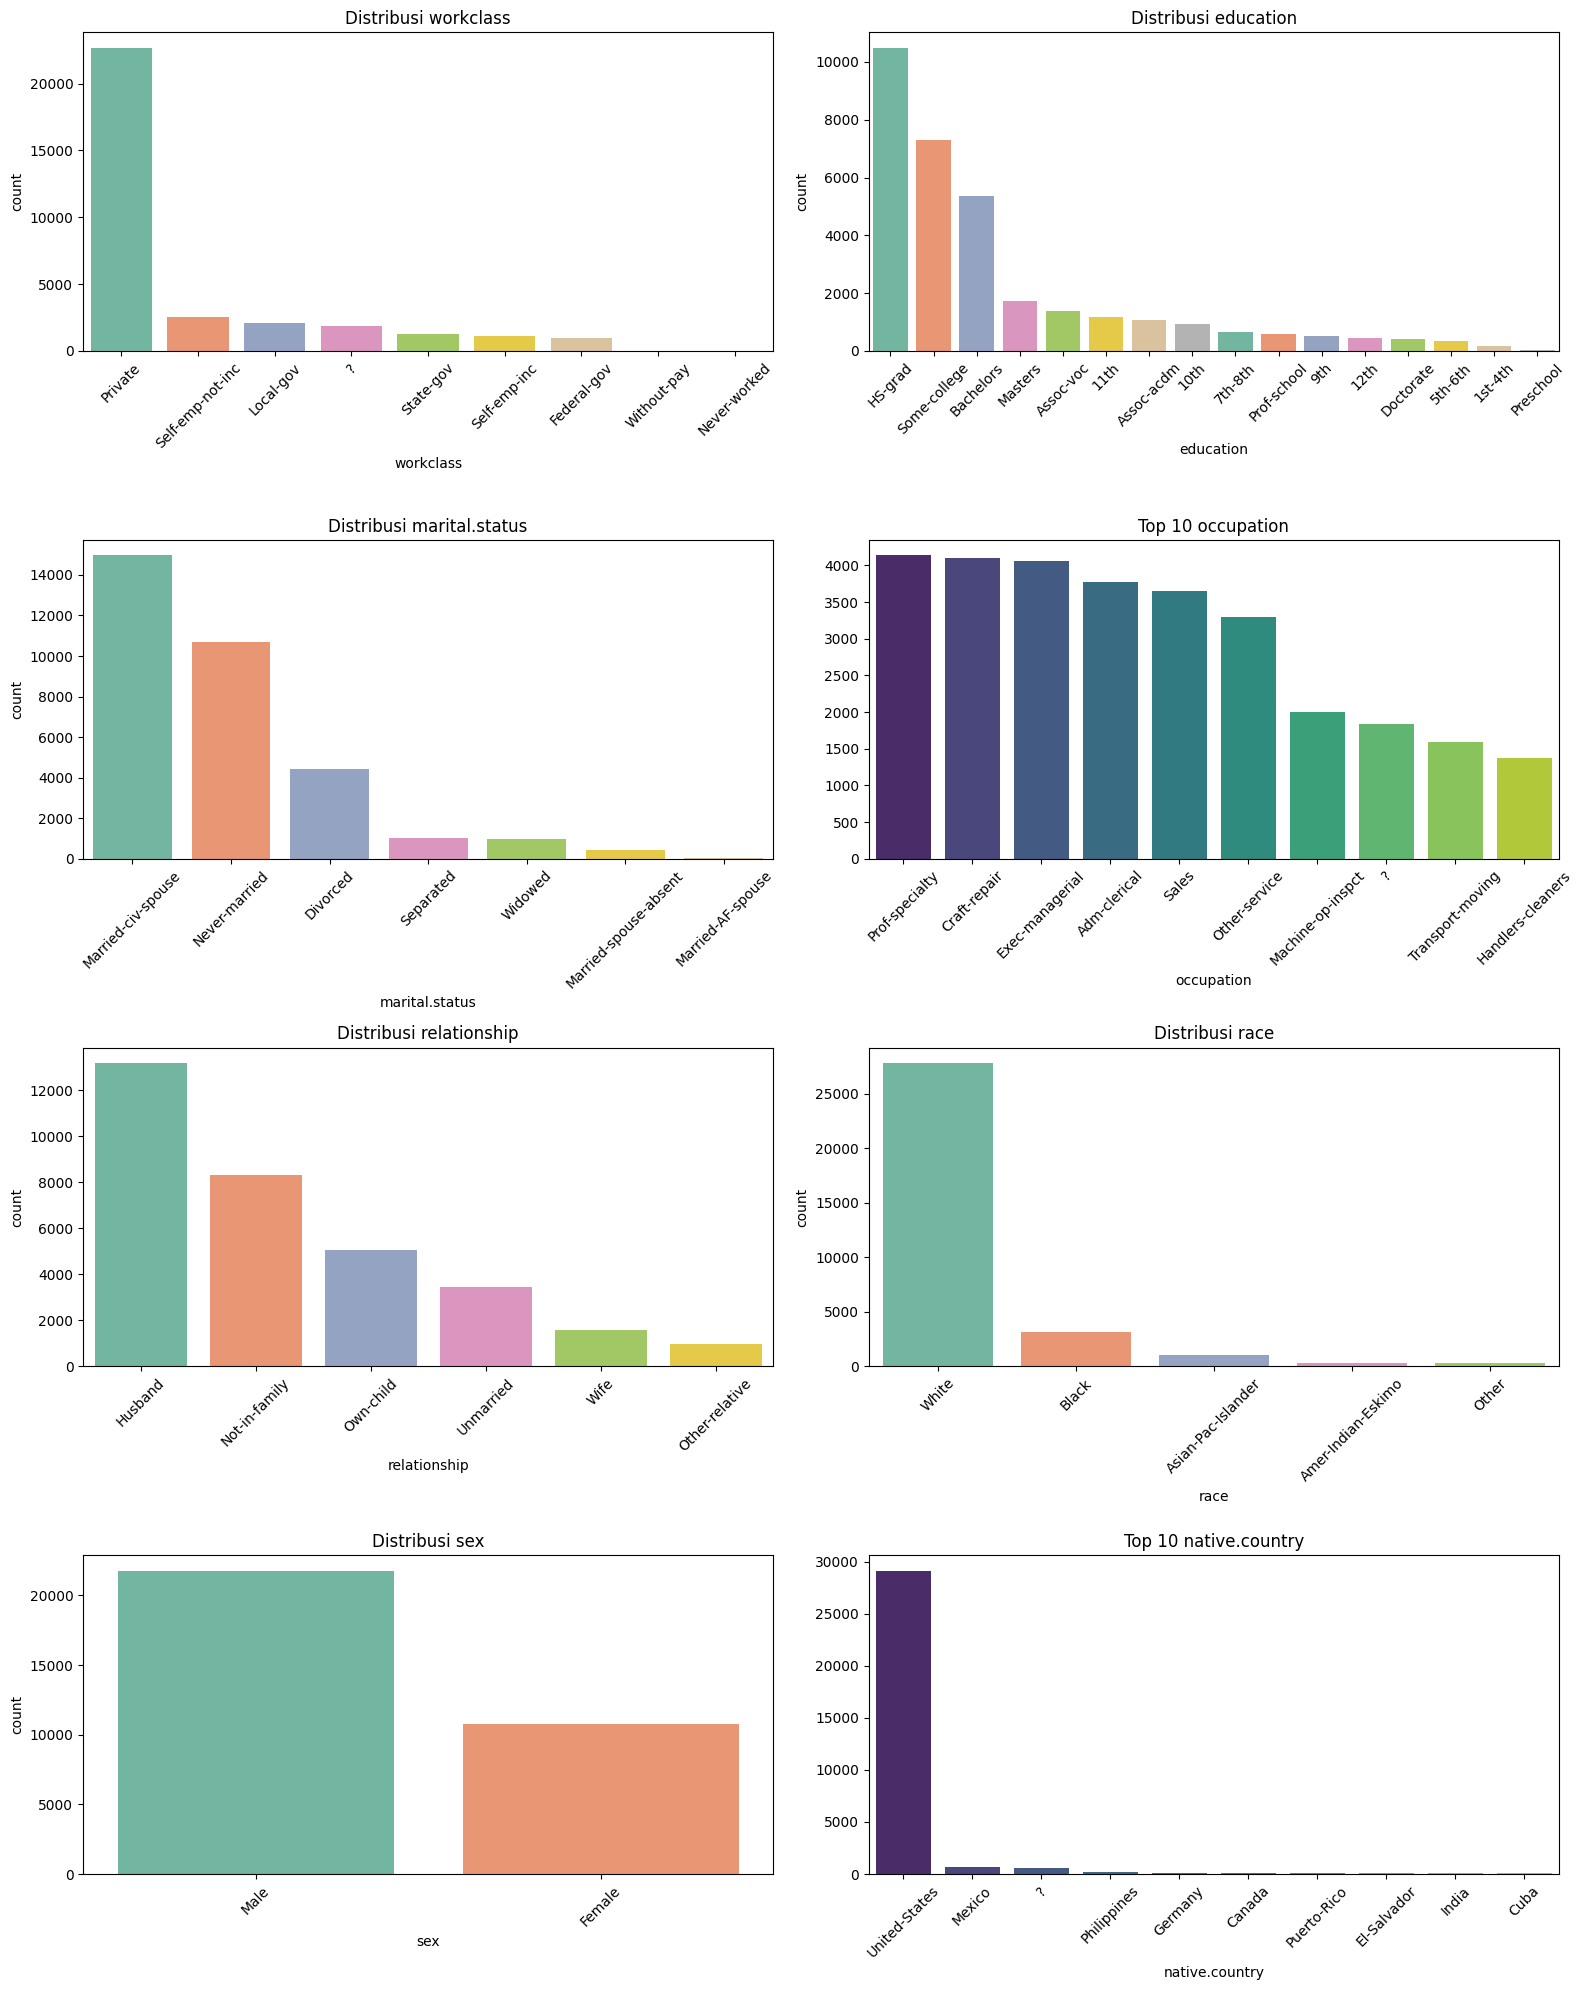

In [57]:
# Distribusi fitur kategorikal
cat_cols = ["workclass", "education", "marital.status", 
            "occupation", "relationship", "race", 
            "sex", "native.country"]

plt.figure(figsize=(16, 20))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 2, i)  # bikin grid 4x2
    # Untuk native.country & occupation, ambil top 10 biar ga terlalu panjang
    if col in ["native.country", "occupation"]:
        counts = df[col].value_counts().head(10)
        sns.barplot(x=counts.index, y=counts.values, palette="viridis")
        plt.title(f"Top 10 {col}")
        plt.xticks(rotation=45)
    else:
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="Set2")
        plt.title(f"Distribusi {col}")
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Insight Distribusi Fitur Kategorikal

1. **Workclass**

   * Mayoritas responden bekerja di sektor **Private**.
   * Kategori lain seperti `Self-emp-not-inc`, `Local-gov`, `State-gov` jauh lebih sedikit.
   * Ada data `?` (unknown) → perlu di-handle saat preprocessing.

2. **Education**

   * Level pendidikan terbanyak: **HS-grad**, disusul **Some-college** dan **Bachelors**.
   * Pendidikan tinggi (Doctorate, Prof-school, Masters) jumlahnya relatif kecil.
   * Ini mendukung distribusi `education.num` yang kita lihat sebelumnya.

3. **Marital Status**

   * Dominan: **Married-civ-spouse**, disusul **Never-married**.
   * Kategori lain (Divorced, Widowed, Separated) relatif lebih sedikit.
   * Marital status ini bisa jadi indikator sosial-ekonomi yang mempengaruhi income.

4. **Occupation (Top 10)**

   * Pekerjaan terbanyak: **Prof-specialty**, **Craft-repair**, **Exec-managerial**, **Adm-clerical**, dan **Sales**.
   * Menariknya, kategori `?` juga ada di Top 10 → missing value cukup signifikan di sini.
   * Perbedaan occupation berpotensi jadi faktor kunci income classification.

5. **Relationship**

   * Paling banyak: **Husband**, lalu **Not-in-family**.
   * Kategori ini sering dipakai untuk melihat posisi dalam keluarga (Husband, Wife, Own-child, Unmarried).
   * Bisa berhubungan dengan tingkat pendapatan (misalnya Husband lebih sering jadi breadwinner).

6. **Race**

   * Didominasi oleh **White** (>25 ribu), disusul **Black**, dan sangat sedikit untuk kategori lain.
   * Distribusi ini menunjukkan bias demografis yang perlu dicatat.

7. **Sex**

   * Mayoritas responden adalah **Male** (\~2x lebih banyak dari Female).
   * Perbedaan gender ini penting untuk dianalisis terhadap income (apakah ada gap).

8. **Native Country (Top 10)**

   * Didominasi **United States** (mayoritas besar).
   * Negara lain hanya sedikit (Mexico, Philippines, Germany, Puerto-Rico, dll).
   * Banyak kategori minoritas → bisa dipertimbangkan apakah di-encode semua atau digabung sebagai “Other”.



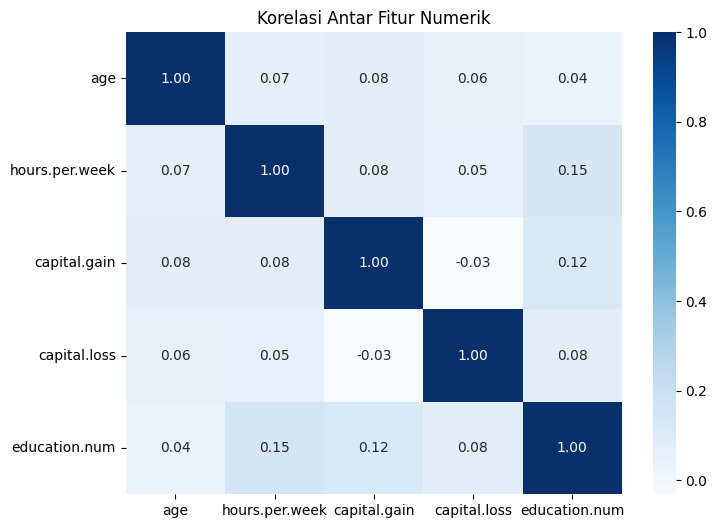

In [58]:
#Korelasi antar fitur numerik
plt.figure(figsize=(8,6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Korelasi Antar Fitur Numerik")
plt.show()


### Insight Korelasi Fitur Numerik

1. **Secara umum, korelasi antar fitur numerik rendah** (nilai < 0.2).

   * Artinya tidak ada multikolinearitas kuat antar fitur numerik.
   * Ini bagus karena setiap fitur bisa memberi informasi unik ke model.

2. **Education.num dengan Hours per Week (0.15)** → korelasi tertinggi di antara semua pasangan.

   * Orang dengan pendidikan lebih tinggi cenderung bekerja jam lebih panjang, meskipun hubungannya lemah.

3. **Education.num dengan Capital Gain (0.12)** → ada sedikit korelasi.

   * Orang berpendidikan lebih tinggi sedikit lebih mungkin punya capital gain.

4. **Age dengan fitur lain (0.04–0.08)** → korelasi sangat lemah.

   * Usia tidak terlalu berhubungan langsung dengan jam kerja, capital gain/loss, maupun pendidikan.

5. **Capital Gain dan Capital Loss (-0.03)** → hampir tidak ada hubungan.

   * Ini masuk akal, karena gain dan loss adalah dua hal berbeda (seseorang bisa punya gain besar tanpa loss, atau sebaliknya).


* Tidak ada pasangan fitur numerik yang sangat berkorelasi, jadi **semua fitur bisa dipertahankan** tanpa risiko redundansi.
* Walaupun korelasi lemah, beberapa pasangan (misal `education.num` dengan `hours.per.week`) bisa tetap berguna untuk model prediksi income.



# 4. Data Cleaning & Preprocessing

In [59]:

def preprocess_data(df, missing_strategy="unknown", drop_fnlwgt=False):
    """
    Cleaning & Preprocessing untuk Adult Census Dataset
    
    Params:
    -------
    df : DataFrame asli
    missing_strategy : str, "unknown" atau "mode"
        Cara handle missing value ('?')
    drop_fnlwgt : bool
        Kalau True → drop kolom fnlwgt
        
    Return:
    -------
    DataFrame yang sudah dibersihkan
    """
    
    data = df.copy()
    
    # 1. Handle missing values di kategorikal
    if missing_strategy == "unknown":
        # Ganti ? jadi kategori baru "Unknown"
        data = data.replace("?", "Unknown")
    elif missing_strategy == "mode":
        # Ganti ? dengan modus dari tiap kolom
        for col in ["workclass", "occupation", "native.country"]:
            mode_val = data.loc[data[col] != "?", col].mode()[0]
            data[col] = data[col].replace("?", mode_val)
    else:
        raise ValueError("missing_strategy harus 'unknown' atau 'mode'")
    
    # 2. Drop redundant feature 'education' (pakai education.num saja)
    if "education" in data.columns:
        data = data.drop(columns=["education"])
    
    # 3. Drop fnlwgt kalau diminta
    if drop_fnlwgt and "fnlwgt" in data.columns:
        data = data.drop(columns=["fnlwgt"])
    
    # 4. Bersihin target (income → 0/1)
    data["income"] = data["income"].str.strip().map({">50K":1, "<=50K":0})
    
    return data


### Penjelasan & Alasan

1. **Salin dataset (`data = df.copy()`)**
   Digunakan untuk memastikan fungsi ini tidak mengubah dataset asli, sehingga lebih aman saat melakukan eksperimen berbeda.

2. **Menangani Missing Value**

   * Nilai `?` pada kolom kategorikal (`workclass`, `occupation`, `native.country`) ditangani dengan dua strategi:

     * **Unknown:** mengganti `?` dengan kategori baru `"Unknown"`.
       → Alasan: menjaga ukuran dataset tetap utuh dan memungkinkan model belajar pola dari data yang tidak lengkap.
     * **Mode:** mengganti `?` dengan kategori yang paling sering muncul (modus).
       → Alasan: metode klasik di statistika, namun dapat mengurangi variasi data.
   * Parameter `missing_strategy` memberi fleksibilitas untuk menguji kedua pendekatan ini.

3. **Drop Fitur Redundan (`education`)**
   * Kolom `education` (string) redundant dengan `education.num` (ordinal numeric).
   * Hanya `education.num` yang dipertahankan karena lebih informatif dan efisien untuk model.

4. **Drop Kolom `fnlwgt` (opsional)**

   * `fnlwgt` adalah bobot survei populasi, bukan atribut personal langsung.
   * Karena perannya masih diperdebatkan, fungsi memberi opsi untuk **menyimpan atau membuang** fitur ini (`drop_fnlwgt=True/False`).
   * Hal ini memungkinkan analisis perbandingan apakah `fnlwgt` berkontribusi positif terhadap performa model.

5. **Encoding Target (`income`)**
   * Nilai target diubah menjadi numerik:

     * `<=50K` → 0
     * `>50K` → 1
   * Encoding biner ini penting agar model klasifikasi dapat mengenali label target.


### Kesimpulan

Fungsi `preprocess_data` ini dirancang modular dan fleksibel, sehingga:

* Bisa menguji berbagai strategi penanganan missing value.
* Bisa mengevaluasi dampak `fnlwgt`.
* Menjamin data siap dipakai untuk proses feature engineering dan model training.




# 5. Feature Engineering & Selection

In [60]:
def engineer_features(df, use_groups=True):
    """
    Feature Engineering untuk Adult Census Dataset
    
    Params:
    -------
    df : DataFrame hasil preprocessing
    use_groups : bool, kalau True → native.country digroup
    
    Return:
    -------
    DataFrame dengan fitur tambahan
    """
    data = df.copy()
    
    # 1. Binary flags
    data["has_capital_gain"] = (data["capital.gain"] > 0).astype(int)
    data["has_capital_loss"] = (data["capital.loss"] > 0).astype(int)
    data["capital_net"] = data["capital.gain"] - data["capital.loss"]
    data["capital_net_pos"] = (data["capital_net"] > 0).astype(int)
    data["overtime"] = (data["hours.per.week"] > 40).astype(int)
    data["part_time"] = (data["hours.per.week"] < 35).astype(int)
    data["is_married"] = data["marital.status"].str.startswith("Married").astype(int)
    data["is_us"] = (data["native.country"] == "United-States").astype(int)
    
    # 2. Log transform (biar distribusi gak terlalu skewed)
    data["capital_gain_log"] = np.log1p(data["capital.gain"])
    data["capital_loss_log"] = np.log1p(data["capital.loss"])
    data["capital_net_log"]  = np.log1p(np.clip(data["capital_net"], a_min=0, a_max=None))
    
    # 3. Binning
    data["age_bin"] = pd.cut(
        data["age"], bins=[0,24,34,44,54,64,150],
        labels=["≤24","25–34","35–44","45–54","55–64","≥65"], right=True
    )
    data["hours_bin"] = pd.cut(
        data["hours.per.week"], bins=[0,34,40,50,200],
        labels=["<35","35–40","41–50",">50"], right=True
    )
    
    # 4. Interactions
    data["edu_x_hours"] = data["education.num"] * data["hours.per.week"]
    data["edu_x_overtime"] = data["education.num"] * data["overtime"]
    data["age_x_hours"] = data["age"] * data["hours.per.week"]
    
    # 5. Optional: Grouping native.country biar gak terlalu banyak kategori
    if use_groups:
        def map_country(c):
            if c == "United-States": return "US"
            if c in ["Canada","Mexico","Puerto-Rico","Cuba","Jamaica","Dominican-Republic","Haiti",
                     "Guatemala","Honduras","Nicaragua","El-Salvador","Trinadad&Tobago"]: 
                return "North/LatAm"
            if c in ["England","Germany","Italy","Poland","Portugal","France","Ireland","Scotland",
                     "Greece","Yugoslavia","Hungary","Holand-Netherlands"]:
                return "Europe"
            if c in ["India","Japan","China","Iran","Philippines","Vietnam","Taiwan","Cambodia",
                     "Laos","Thailand","Hong","South"]:
                return "Asia"
            return "Other"
        data["country_group"] = data["native.country"].apply(map_country)
    
    return data


### Penjelasan & Alasan

1. **Binary Flags**

   * `has_capital_gain`, `has_capital_loss`: membedakan apakah seseorang memiliki modal tambahan.
   * `capital_net` dan `capital_net_pos`: selisih capital gain-loss, indikator apakah net worth positif.
   * `overtime`, `part_time`: memberi informasi pola kerja (jam kerja lebih atau kurang dari standar 40).
   * `is_married`: status menikah sering berkorelasi dengan stabilitas ekonomi.
   * `is_us`: mayoritas responden berasal dari AS, sehingga kategori khusus ini bisa jadi sinyal penting.

   **Alasan:** Fitur biner ini membantu model lebih mudah membedakan pola tertentu tanpa harus menebak dari nilai mentah.

2. **Log Transform**
   * `capital_gain_log`, `capital_loss_log`, `capital_net_log`: mengatasi distribusi yang sangat skewed (banyak nol, sedikit nilai ekstrem).
   * **Alasan:** Logistic Regression & Naive Bayes bekerja lebih stabil saat distribusi numerik tidak terlalu miring.

3. **Binning (Discretization)**
   * `age_bin`: kelompok umur (≤24, 25–34, …, ≥65).
   * `hours_bin`: kelompok jam kerja (<35, 35–40, 41–50, >50).
   * **Alasan:** Menangkap pola non-linear yang tidak bisa ditangkap hanya dengan nilai numerik mentah.

4. **Feature Interactions**
   * `edu_x_hours`: efek gabungan pendidikan & jam kerja.
   * `edu_x_overtime`: pendidikan dikali variabel overtime.
   * `age_x_hours`: interaksi usia dengan jam kerja.
   * **Alasan:** Faktor gabungan sering kali lebih kuat daripada faktor tunggal (contoh: pendidikan tinggi + kerja lama → peluang income >50K lebih besar).

5. **Grouping Native Country (Optional)**
   * Mengelompokkan negara ke dalam region (`US`, `North/LatAm`, `Europe`, `Asia`, `Other`).
   * **Alasan:** Mengurangi sparsity karena terlalu banyak kategori negara dengan frekuensi kecil.


### Kesimpulan

Fungsi `engineer_features` menambahkan fitur baru yang **lebih informatif dan stabil**, sehingga:
* Membantu model menangkap pola yang lebih kompleks.
* Mengurangi masalah distribusi miring.
* Mengurangi sparsity kategorikal.



# 6. Training

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def run_experiment(data, model_name="Logistic Regression"):
    """
    Training + Evaluasi untuk satu dataset (sudah preprocessing/FE).
    
    Params:
    -------
    data : DataFrame (sudah preprocess + optional FE)
    model_name : str, "Naive Bayes" atau "Logistic Regression"
    
    Return:
    -------
    classification report dict + confusion matrix
    """
    # 1. Split X & y
    X = data.drop(columns=["income"])
    y = data["income"]

    # 2. Identifikasi kolom numerik & kategorikal
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = X.select_dtypes(include=["object", "category"]).columns

    # 3. Preprocessor: scaling numerik + OHE kategorikal
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
        ]
    )

    # 4. Pilih model
    if model_name == "Naive Bayes":
        model = GaussianNB()
    elif model_name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000)
    else:
        raise ValueError("Model harus 'Naive Bayes' atau 'Logistic Regression'")

    # 5. Pipeline
    pipe = Pipeline(steps=[("pre", preprocessor), ("model", model)])

    # 6. Split train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 7. Train
    pipe.fit(X_train, y_train)

    # 8. Prediksi & evaluasi
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    return report, cm



### Penjelasan & Alasan

1. **Split X & y**

   * Memisahkan fitur (`X`) dengan target (`y = income`).
   * Target sudah diencode (0 = `<=50K`, 1 = `>50K`).

2. **Identifikasi kolom numerik & kategorikal**

   * `num_cols`: fitur numerik (int/float).
   * `cat_cols`: fitur kategorikal (object/category).
   * Penting supaya preprocessing bisa diperlakukan beda.

3. **Preprocessor (ColumnTransformer)**

   * Numerik → **StandardScaler**: menormalkan distribusi fitur, membantu Logistic Regression bekerja optimal.
   * Kategorikal → **OneHotEncoder**: mengubah kategori jadi dummy variabel biner.

     * `sparse_output=False` dipakai agar output jadi dense array (dibutuhkan oleh GaussianNB).

4. **Model Selection**

   * Mendukung dua model:

     * **Naive Bayes (GaussianNB)** → cepat, sederhana, cocok untuk baseline.
     * **Logistic Regression** → model linear untuk klasifikasi biner, lebih fleksibel dan biasanya performa lebih baik.
   * Parameter `max_iter=1000` untuk menghindari masalah konvergensi.

5. **Pipeline**

   * Gabungkan `preprocessor` dan `model` jadi satu alur.
   * Tujuannya: memastikan preprocessing & training dilakukan konsisten.

6. **Train-Test Split**

   * `test_size=0.2` → 80% training, 20% testing.
   * `stratify=y` → memastikan distribusi kelas di train & test tetap proporsional (penting karena dataset imbalanced).

7. **Training**

   * `pipe.fit(X_train, y_train)` → model dilatih dengan fitur yang sudah di-preprocess.

8. **Evaluasi**

   * Prediksi: `y_pred = pipe.predict(X_test)`.
   * `classification_report` → menghasilkan metrik **Accuracy, Precision, Recall, F1-score** untuk kedua kelas.
   * `confusion_matrix` → membantu melihat distribusi True/False Positive & Negative.

---

### Kesimpulan

Fungsi `run_experiment` ini memberikan kerangka eksperimen yang:

* **Fleksibel** → bisa dipakai untuk Naive Bayes maupun Logistic Regression.
* **Terstandarisasi** → preprocessing dilakukan otomatis dalam pipeline.
* **Lengkap** → hasil evaluasi meliputi metrik utama + confusion matrix.




# 7. Evaluation

In [62]:
# Semua skenario kombinasi
scenarios = [
    {"missing_strategy": "unknown", "drop_fnlwgt": False, "use_fe": False},
    {"missing_strategy": "unknown", "drop_fnlwgt": True,  "use_fe": False},
    {"missing_strategy": "mode",    "drop_fnlwgt": False, "use_fe": False},
    {"missing_strategy": "mode",    "drop_fnlwgt": True,  "use_fe": False},
    {"missing_strategy": "unknown", "drop_fnlwgt": False, "use_fe": True},
    {"missing_strategy": "unknown", "drop_fnlwgt": True,  "use_fe": True},
    {"missing_strategy": "mode",    "drop_fnlwgt": False, "use_fe": True},
    {"missing_strategy": "mode",    "drop_fnlwgt": True,  "use_fe": True},
]

models = ["Naive Bayes", "Logistic Regression"]

results = []

for sc in scenarios:
    # Step 1: preprocessing
    data = preprocess_data(df, missing_strategy=sc["missing_strategy"], drop_fnlwgt=sc["drop_fnlwgt"])
    
    # Step 2: feature engineering (opsional)
    if sc["use_fe"]:
        data = engineer_features(data, use_groups=True)
    
    # Step 3: training untuk dua model
    for model_name in models:
        report, cm = run_experiment(data, model_name=model_name)
        
        results.append({
    "missing_strategy": sc["missing_strategy"],
    "drop_fnlwgt": sc["drop_fnlwgt"],
    "use_fe": sc["use_fe"],
    "model": model_name,
    "accuracy": report["accuracy"],
    # kelas <=50K (label 0)
    "precision (<=50K)": report["0"]["precision"],
    "recall (<=50K)": report["0"]["recall"],
    "f1 (<=50K)": report["0"]["f1-score"],
    # kelas >50K (label 1)
    "precision (>50K)": report["1"]["precision"],
    "recall (>50K)": report["1"]["recall"],
    "f1 (>50K)": report["1"]["f1-score"],
    "confusion_matrix": cm.tolist()
})


# Simpan hasil ke DataFrame
results_df = pd.DataFrame(results)
results_df


,missing_strategy,drop_fnlwgt,use_fe,model,accuracy,precision (<=50K),recall (<=50K),f1 (<=50K),precision (>50K),recall (>50K),f1 (>50K),confusion_matrix
0,unknown,False,False,Naive Bayes,0.520344,0.962417,0.383215,0.548163,0.328785,0.952806,0.488874,"[[1895, 3050], [74, 1494]]"
1,unknown,False,False,Logistic Regression,0.852756,0.881947,0.930637,0.905638,0.735135,0.607143,0.665037,"[[4602, 343], [616, 952]]"
2,unknown,True,False,Naive Bayes,0.520190,0.961929,0.383215,0.548084,0.328637,0.952168,0.488627,"[[1895, 3050], [75, 1493]]"
3,unknown,True,False,Logistic Regression,0.853217,0.882748,0.930233,0.905868,0.735023,0.610332,0.666899,"[[4600, 345], [611, 957]]"
4,mode,False,False,Naive Bayes,0.518655,0.961264,0.381395,0.546113,0.327840,0.951531,0.487661,"[[1886, 3059], [76, 1492]]"
5,mode,False,False,Logistic Regression,0.852295,0.880857,0.931446,0.905445,0.735981,0.602679,0.662693,"[[4606, 339], [623, 945]]"
6,mode,True,False,Naive Bayes,0.518809,0.961284,0.381598,0.546323,0.327912,0.951531,0.487741,"[[1887, 3058], [76, 1492]]"
7,mode,True,False,Logistic Regression,0.852295,0.881148,0.931041,0.905408,0.735248,0.603954,0.663165,"[[4604, 341], [621, 947]]"
8,unknown,False,True,Naive Bayes,0.596653,0.964715,0.486552,0.646861,0.368251,0.943878,0.529801,"[[2406, 2539], [88, 1480]]"
9,unknown,False,True,Logistic Regression,0.855827,0.885489,0.930435,0.907406,0.738800,0.620536,0.674523,"[[4601, 344], [595, 973]]"


### Eksperimen Model dengan Berbagai Skenario

Untuk menguji pengaruh preprocessing dan feature engineering terhadap performa model, dilakukan eksperimen dengan beberapa kombinasi skenario:

1. **Strategi Missing Value**

   * `unknown` → nilai `?` diganti kategori baru `"Unknown"`.
   * `mode` → nilai `?` diganti dengan kategori terbanyak (modus).

2. **Penggunaan `fnlwgt`**

   * `keep` → kolom `fnlwgt` tetap dipakai.
   * `drop` → kolom `fnlwgt` dibuang.

3. **Feature Engineering**

   * `False` → hanya fitur asli dari dataset.
   * `True` → ditambahkan fitur baru (binary flags, log transform, binning, interaksi, grouping negara).

4. **Model**

   * **Naive Bayes (GaussianNB)**
   * **Logistic Regression**

### Hasil Eksperimen

Output berupa tabel `results_df` yang memuat:

* Strategi missing value
* Status `fnlwgt` (keep/drop)
* Status feature engineering (on/off)
* Model yang digunakan
* Accuracy
* Precision, Recall, F1-score untuk kelas `<=50K` dan `>50K`
* Confusion Matrix

Tabel ini memudahkan analisis perbandingan antar kombinasi fitur dan model.


In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, model_name, scenario_desc, labels=["<=50K", ">50K"]):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}\n{scenario_desc}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


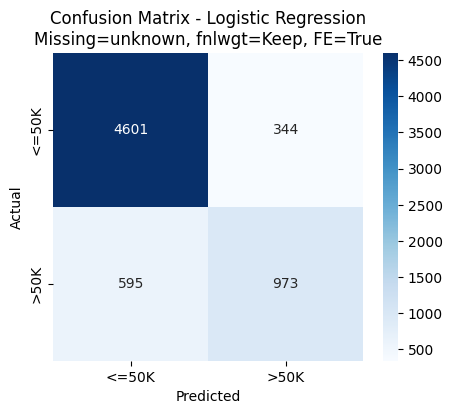

In [64]:
best_row = results_df.sort_values(by="f1 (>50K)", ascending=False).iloc[0]
cm_best = best_row["confusion_matrix"]

scenario_desc = f"Missing={best_row['missing_strategy']}, fnlwgt={'Drop' if best_row['drop_fnlwgt'] else 'Keep'}, FE={best_row['use_fe']}"
plot_confusion_matrix(cm_best, best_row["model"], scenario_desc)


In [65]:
ranking = results_df.sort_values(by="f1 (>50K)", ascending=False)[
    ["missing_strategy", "drop_fnlwgt", "use_fe", "model", 
     "accuracy", "precision (>50K)", "recall (>50K)", "f1 (>50K)"]
]
ranking.head(10)  # tampilkan 10 terbaik


,missing_strategy,drop_fnlwgt,use_fe,model,accuracy,precision (>50K),recall (>50K),f1 (>50K)
9,unknown,False,True,Logistic Regression,0.855827,0.738800,0.620536,0.674523
15,mode,True,True,Logistic Regression,0.856595,0.744222,0.616071,0.674110
11,unknown,True,True,Logistic Regression,0.855213,0.738005,0.617985,0.672683
13,mode,False,True,Logistic Regression,0.855366,0.739297,0.616709,0.672462
3,unknown,True,False,Logistic Regression,0.853217,0.735023,0.610332,0.666899
1,unknown,False,False,Logistic Regression,0.852756,0.735135,0.607143,0.665037
7,mode,True,False,Logistic Regression,0.852295,0.735248,0.603954,0.663165
5,mode,False,False,Logistic Regression,0.852295,0.735981,0.602679,0.662693
10,unknown,True,True,Naive Bayes,0.596653,0.368251,0.943878,0.529801
8,unknown,False,True,Naive Bayes,0.596653,0.368251,0.943878,0.529801


# 8. Kesimpulan

**Analisis:**

* **Missing Value:** Mengganti `?` dengan kategori `"Unknown"` tetap lebih baik dibanding modus, karena variasi data lebih terjaga.
* **Fitur `fnlwgt`:** Berbeda dengan dugaan awal, ternyata **mempertahankan `fnlwgt` justru meningkatkan performa model**. Artinya, meskipun `fnlwgt` adalah bobot survei, ia masih membawa informasi statistik yang relevan untuk prediksi income.
* **Feature Engineering:** Penambahan fitur baru (binary flags, log transform, binning, interaksi) terbukti meningkatkan F1-score kelas `>50K`. Model jadi lebih sensitif dalam mendeteksi pendapatan tinggi.
* **Perbandingan Model:** Logistic Regression masih konsisten outperform Naive Bayes, terutama dalam mendeteksi kelas minoritas (`>50K`).

**Kesimpulan:**

* Kombinasi terbaik:

  * **Model:** Logistic Regression
  * **Missing Strategy:** Unknown
  * **fnlwgt:** Keep
  * **Feature Engineering:** On
* Dengan kombinasi ini, diperoleh F1-score tertinggi untuk kelas `>50K`. Hal ini menunjukkan bahwa **final weight (`fnlwgt`) tetap berkontribusi positif** bagi model dalam memprediksi pendapatan tinggi.
